In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
cat_df=pd.read_csv('C:/Users/missa/OneDrive/Bureau/Cours_Bihar/TPT/Data/Catalogue.csv',encoding='latin-1')
cat_df.head()

,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix
0,Volvo,S80 T6,272,très longue,5,5,blanc,False,50500
1,Volvo,S80 T6,272,très longue,5,5,noir,False,50500
2,Volvo,S80 T6,272,très longue,5,5,rouge,False,50500
3,Volvo,S80 T6,272,très longue,5,5,gris,True,35350
4,Volvo,S80 T6,272,très longue,5,5,bleu,True,35350


### Exploration de données

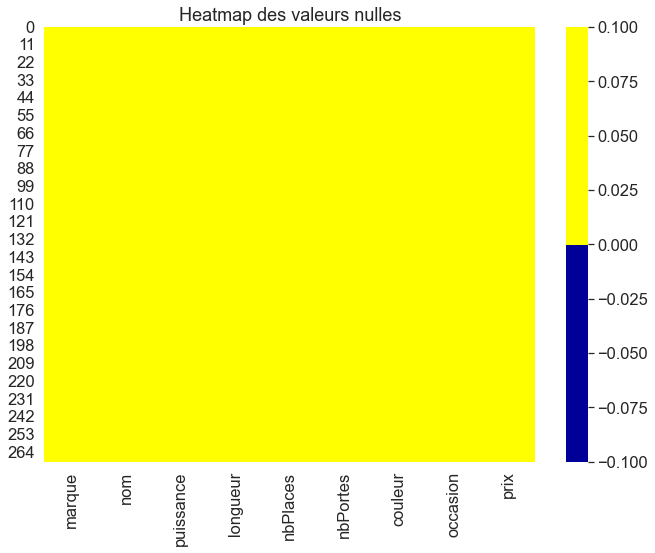

In [18]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(cat_df.isnull(),cmap=sns.color_palette(colours))
plt.title('Heatmap des valeurs nulles')
plt.show()


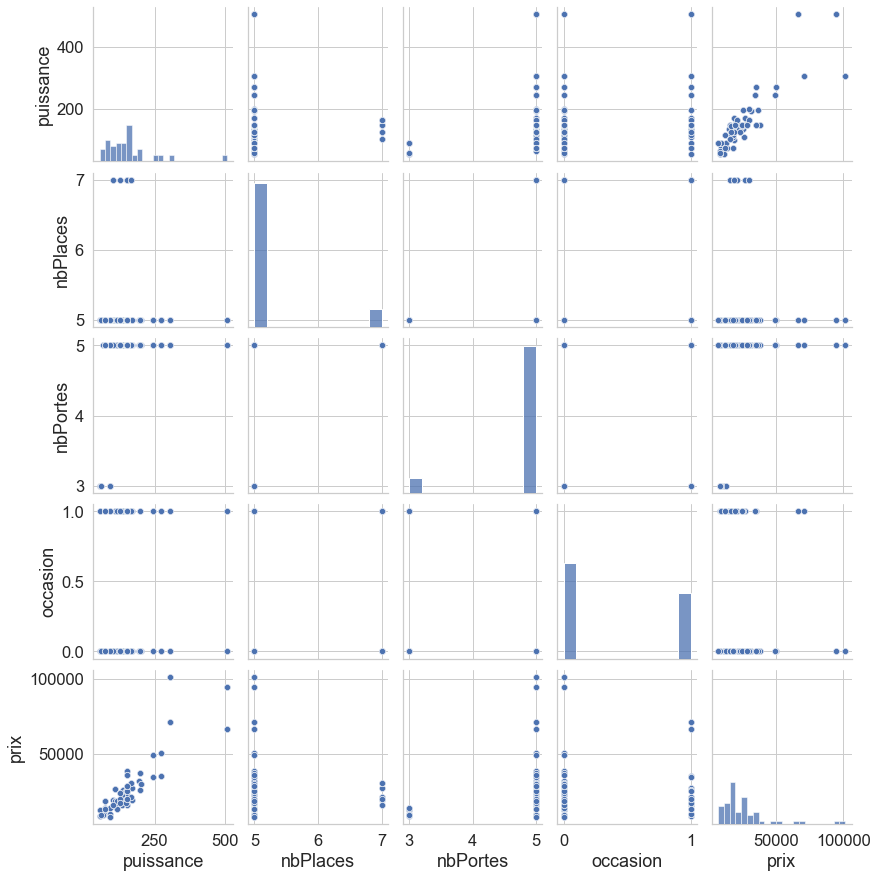

In [19]:
cat_df.occasion = cat_df.occasion.replace({True: 1, False: 0})
sns.pairplot(cat_df)
plt.show()

D'apres les résultats ci-dessus, on peut en déduire que:
- Il y a une corrélation linéaire entre la puissance et le prix.
- Les voitures neuves on tendance à etre plus chère.
- Les voitures à 3 portes sont beaucoup moins chères que les voitures à 5 portes
- Les voitures à 7 places sont plus rares que les voitures à 5 places

On peut penser à catégoriser les voitures selon leurs nombre de portes, de places et leurs puissances/prix.

## Etude des variables catégorielles

In [20]:
cat_df.describe(include=object)

,marque,nom,longueur,couleur
count,270,270,270,270
unique,21,32,4,5
top,Renault,S80 T6,longue,blanc
freq,40,10,90,54


In [21]:
cat_df=cat_df.drop(columns='couleur')

In [22]:
cat_df.marque.value_counts()

Renault       40
Volkswagen    40
Audi          20
Mercedes      20
BMW           20
Nissan        15
Fiat          10
Ford          10
Jaguar        10
Volvo         10
Mini          10
Peugeot       10
Saab          10
Lancia        10
Kia            5
Hyundaï        5
Honda          5
Seat           5
Daihatsu       5
Dacia          5
Skoda          5
Name: marque, dtype: int64

Text(0.5, 1.0, 'Distribution des prix par rapport aux marques')

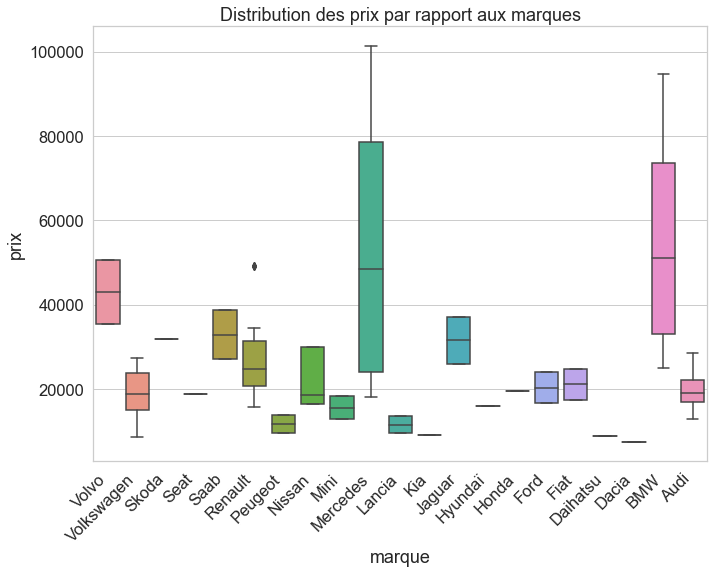

In [23]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

ax = sns.boxplot(x=cat_df['marque'],y=cat_df['prix'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Distribution des prix par rapport aux marques')


Text(0.5, 1.0, 'Distribution des prix par rapport aux Modèles')

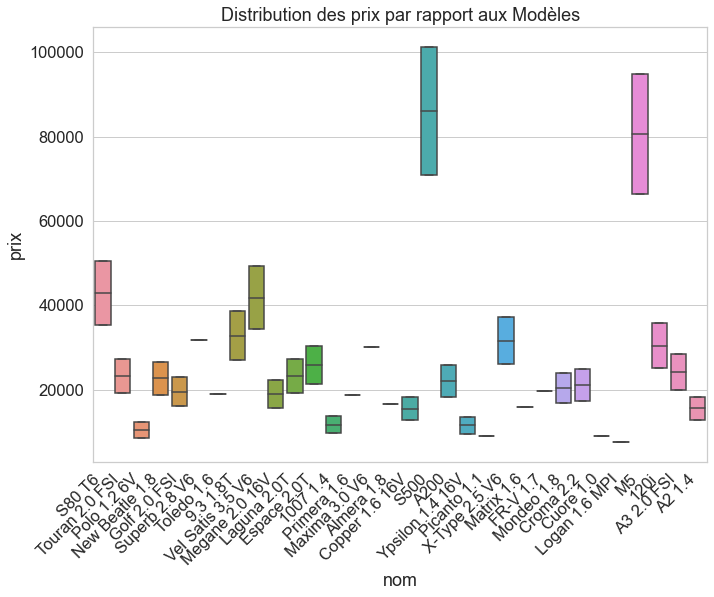

In [24]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

ax = sns.boxplot(x=cat_df['nom'],y=cat_df['prix'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Distribution des prix par rapport aux Modèles')


On peut remarquer une distribution plus ou moins similaire entre ces deux variables, pour le reste de notre travail, on choisit de les fusionner en une seule variable.

In [25]:
cat_df['full_name']=cat_df.marque+'_'+cat_df.nom
cat_df=cat_df.drop(columns=['marque','nom'])
cat_df

,puissance,longueur,nbPlaces,nbPortes,occasion,prix,full_name
0,272,très longue,5,5,0,50500,Volvo_S80 T6
1,272,très longue,5,5,0,50500,Volvo_S80 T6
2,272,très longue,5,5,0,50500,Volvo_S80 T6
3,272,très longue,5,5,1,35350,Volvo_S80 T6
4,272,très longue,5,5,1,35350,Volvo_S80 T6
...,...,...,...,...,...,...,...
265,75,courte,5,5,0,18310,Audi_A2 1.4
266,75,courte,5,5,0,18310,Audi_A2 1.4
267,75,courte,5,5,1,12817,Audi_A2 1.4
268,75,courte,5,5,1,12817,Audi_A2 1.4


## Analyse bivariée des variables catégorielles

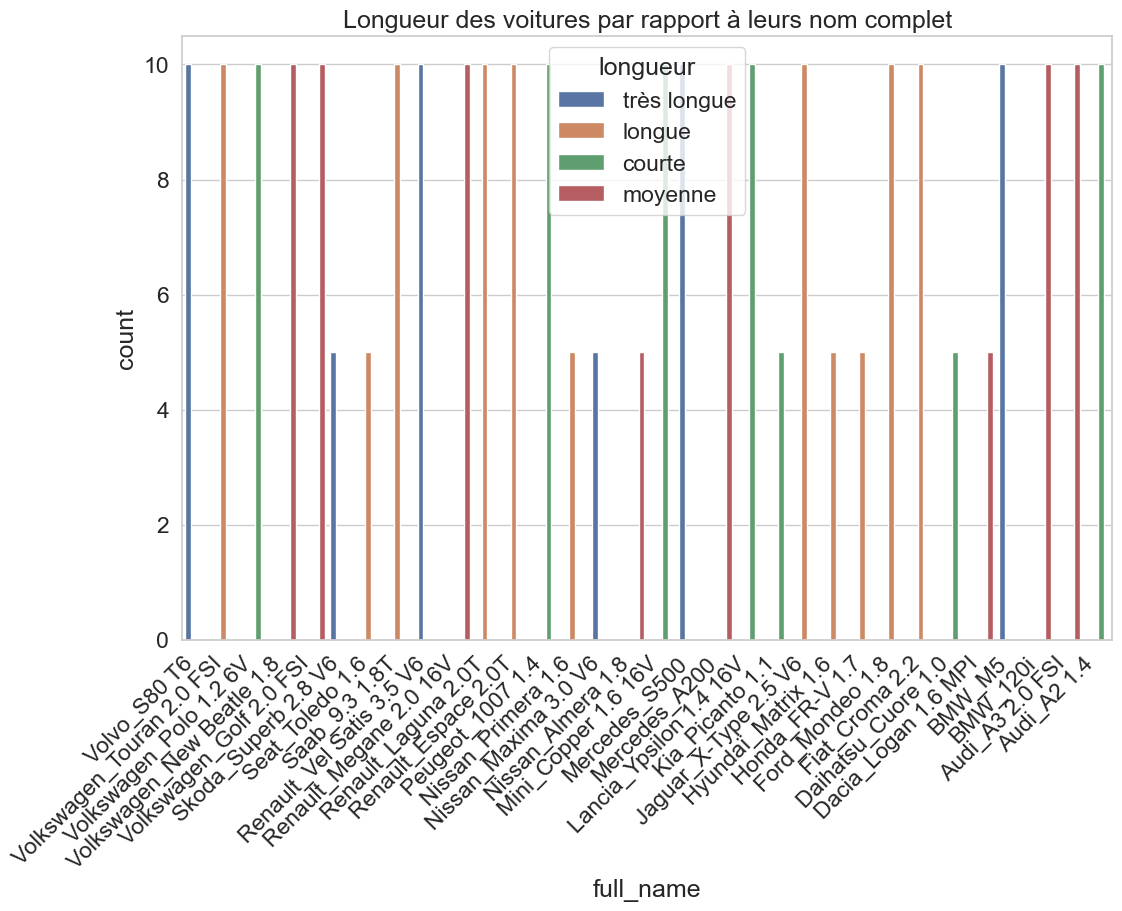

In [26]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax=sns.countplot(x=cat_df.full_name,hue=cat_df.longueur, )
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Longueur des voitures par rapport à leurs nom complet')
plt.show()

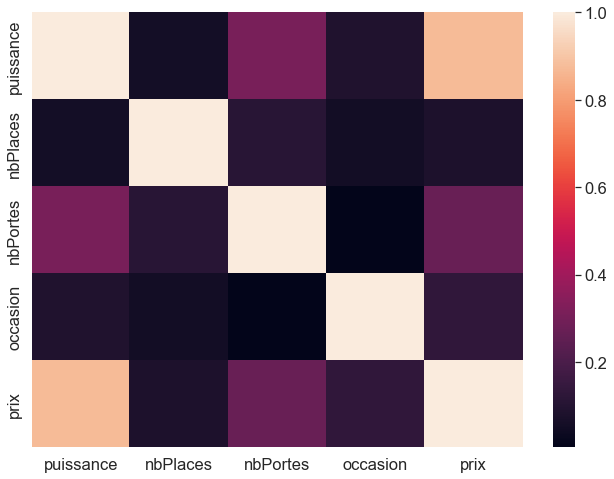

In [27]:
g = sns.heatmap(cat_df.corr().abs())

Suite à ces analyses, on va retenir les variables Marque, Longueur, Prix, NbPlaces, nbPortes, occasion et puissance pour faire le clustering des voitures.

## Processing et clustering

In [28]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [29]:
cat_df.columns

Index(['puissance', 'longueur', 'nbPlaces', 'nbPortes', 'occasion', 'prix',
       'full_name'],
      dtype='object')

In [30]:
categorical=['longueur','occasion','full_name']
numeric_features=['puissance','nbPlaces','nbPortes','prix']

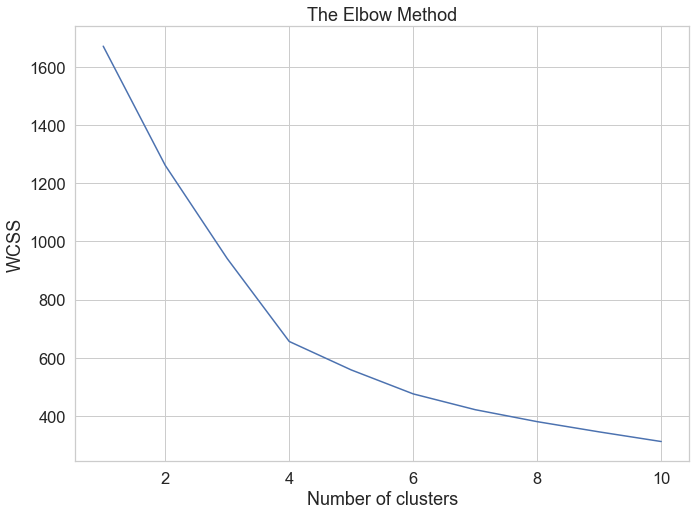

In [31]:
# elbow Method
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
label=['citadine','routiere','sportive','SUV','familiale']
wcss=[]
for i in range (1,11):
    pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('Kmeans', KMeans(n_clusters=i,init='k-means++', max_iter=100, random_state=0))
    ])
    model=pipeline.fit(cat_df)
    wcss.append(model.named_steps['Kmeans'].inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [32]:
from sklearn import preprocessing
cat_dfe=pd.get_dummies(data=cat_df, columns=categorical)
dfe=preprocessing.MinMaxScaler().fit_transform(cat_dfe)
scaled_features_df = pd.DataFrame(dfe, index=cat_dfe.index, columns=cat_dfe.columns)

scaled_features_df

,puissance,nbPlaces,nbPortes,prix,longueur_courte,longueur_longue,longueur_moyenne,longueur_très longue,occasion_0,occasion_1,...,full_name_Renault_Megane 2.0 16V,full_name_Renault_Vel Satis 3.5 V6,full_name_Saab_9.3 1.8T,full_name_Seat_Toledo 1.6,full_name_Skoda_Superb 2.8 V6,full_name_Volkswagen_Golf 2.0 FSI,full_name_Volkswagen_New Beatle 1.8,full_name_Volkswagen_Polo 1.2 6V,full_name_Volkswagen_Touran 2.0 FSI,full_name_Volvo_S80 T6
0,0.480088,0.0,1.0,0.458422,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.480088,0.0,1.0,0.458422,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.480088,0.0,1.0,0.458422,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.480088,0.0,1.0,0.296908,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.480088,0.0,1.0,0.296908,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.044248,0.0,1.0,0.115245,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266,0.044248,0.0,1.0,0.115245,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267,0.044248,0.0,1.0,0.056684,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268,0.044248,0.0,1.0,0.056684,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Silhouette score for k(clusters) = 3 is 0.2112214760310312
Silhouette score for k(clusters) = 4 is 0.27425105561519425
Silhouette score for k(clusters) = 5 is 0.25718069470626326
Silhouette score for k(clusters) = 6 is 0.2743156966329608
Silhouette score for k(clusters) = 7 is 0.29899870621998287
Silhouette score for k(clusters) = 8 is 0.31629903723346325
Silhouette score for k(clusters) = 9 is 0.3245445045617161
Silhouette score for k(clusters) = 10 is 0.33861049576886487
Silhouette score for k(clusters) = 11 is 0.346492245088493
Silhouette score for k(clusters) = 12 is 0.33633293477003345


<AxesSubplot:xlabel='Clusters', ylabel='Sil Score'>

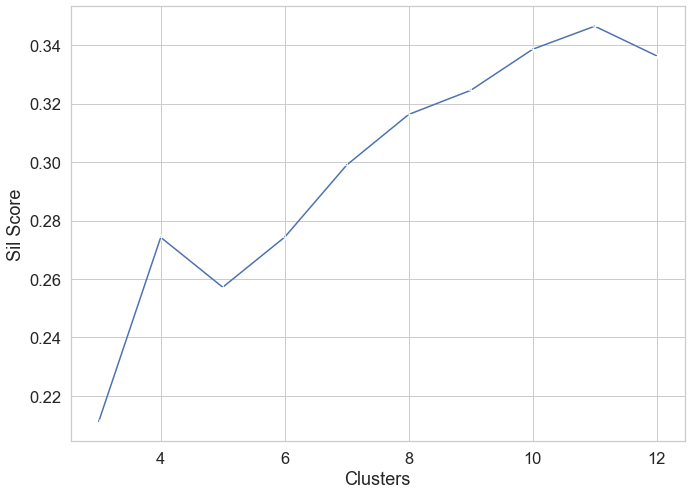

In [33]:
import sklearn.cluster as cluster
import sklearn.metrics as metrics
SK = range(3,13)
sil_score = []
for i in SK:
    labels=cluster.KMeans(n_clusters=i,init="k-means++",random_state=200).fit(scaled_features_df).labels_
    score = metrics.silhouette_score(scaled_features_df,labels,metric="euclidean",sample_size=1000,random_state=200)
    sil_score.append(score)
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(scaled_features_df,labels,metric="euclidean",sample_size=1000,random_state=200)))
sil_centers = pd.DataFrame({'Clusters' : SK, 'Sil Score' : sil_score})
sil_centers     
sns.lineplot(x = 'Clusters', y = 'Sil Score', data = sil_centers, marker="+")      

D'apres ces deux méthodes ci-dessus, on retiendra le nombre de cluster à 4 pour le k-means.

{'icoord': [[35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [15.0, 15.0, 32.5, 32.5],
  [5.0, 5.0, 23.75, 23.75],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [65.0, 65.0, 82.5, 82.5],
  [55.0, 55.0, 73.75, 73.75],
  [14.375, 14.375, 64.375, 64.375],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [115.0, 115.0, 132.5, 132.5],
  [105.0, 105.0, 123.75, 123.75],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [165.0, 165.0, 182.5, 182.5],
  [155.0, 155.0, 173.75, 173.75],
  [114.375, 114.375, 164.375, 164.375],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [215.0, 215.0, 232.5, 232.5],
  [205.0, 205.0, 223.75, 223.75],
  [285.0, 285.0, 295.0, 295.0],
  [275.0, 275.0, 290.0, 290.0],
  [265.0, 265.0, 282.5, 282.5],
  [255.0, 255.0, 273.75, 273.75],
  [214.375, 214.375, 264.375, 264.375],
  [139.375, 139.375, 239.375, 239.375],
  [39.375, 39.375, 189.375, 189.375],
  [335.0, 335.0, 345.0, 345.0],
  [325.0, 325.0, 3

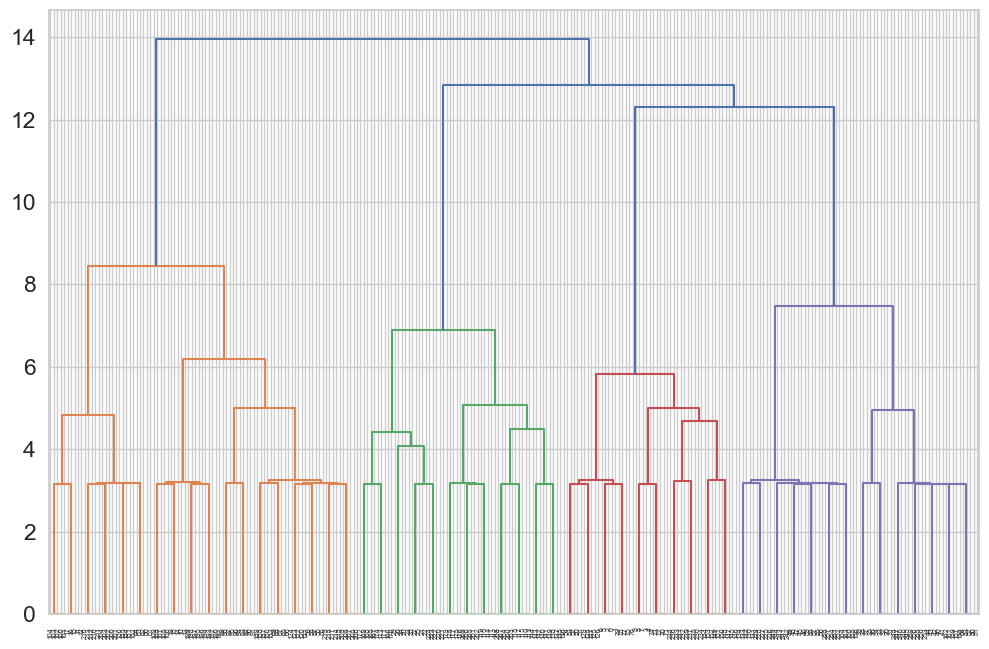

In [34]:
import scipy.cluster.hierarchy as shc
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

dend=shc.dendrogram(shc.linkage(scaled_features_df,method='ward'))
display(dend)

Le dendrogramme affiche clairement 4 clusters principaux, tout comme le nombre de clusters qu'on va choisir pour le k-means.

In [35]:
cat_df.columns

Index(['puissance', 'longueur', 'nbPlaces', 'nbPortes', 'occasion', 'prix',
       'full_name'],
      dtype='object')

In [36]:
def visualize_clusters(df, num_clusters,title,kmeans):
    colors = ['b', 'g', 'r', 'c']
    
    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['puissance'], clustered_df['prix'], c=colors[n-1])
        plt.xlabel('puissance', fontsize=13)
        plt.ylabel('prix', fontsize=13)
        plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='*',label='centroid')

    plt.title(title)
    plt.show()

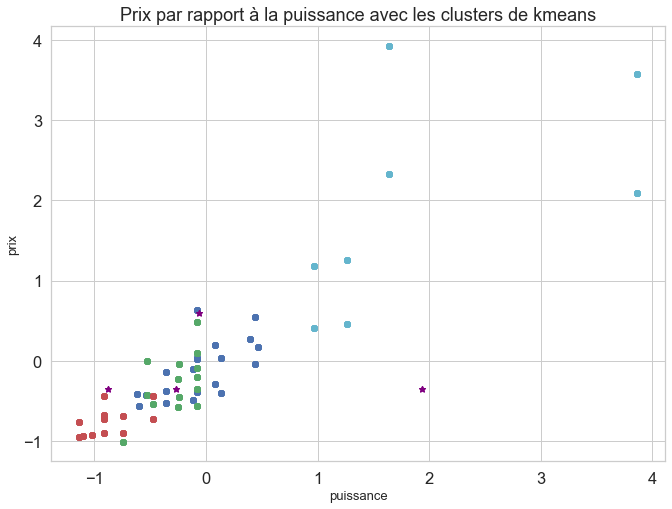

In [37]:
cat_dfe=pd.get_dummies(data=cat_df[['puissance', 'longueur', 'nbPlaces', 'nbPortes', 'occasion', 'prix','full_name']], columns=categorical)
dfe=preprocessing.StandardScaler().fit_transform(cat_dfe)
scaled_features_df = pd.DataFrame(dfe, index=cat_dfe.index, columns=cat_dfe.columns)
kmeans=KMeans(n_clusters=4, max_iter=100, random_state=0)
kmeans.fit(scaled_features_df)
scaled_features_df['cluster']=kmeans.labels_
visualize_clusters(scaled_features_df, 4,'Prix par rapport à la puissance avec les clusters de kmeans',kmeans)


In [38]:
dfe=preprocessing.StandardScaler().fit_transform(cat_dfe)
scaled_features_df = pd.DataFrame(dfe, index=cat_dfe.index, columns=cat_dfe.columns)

In [39]:
scaled_features_df.shape

(270, 42)

## Visualisation par pca

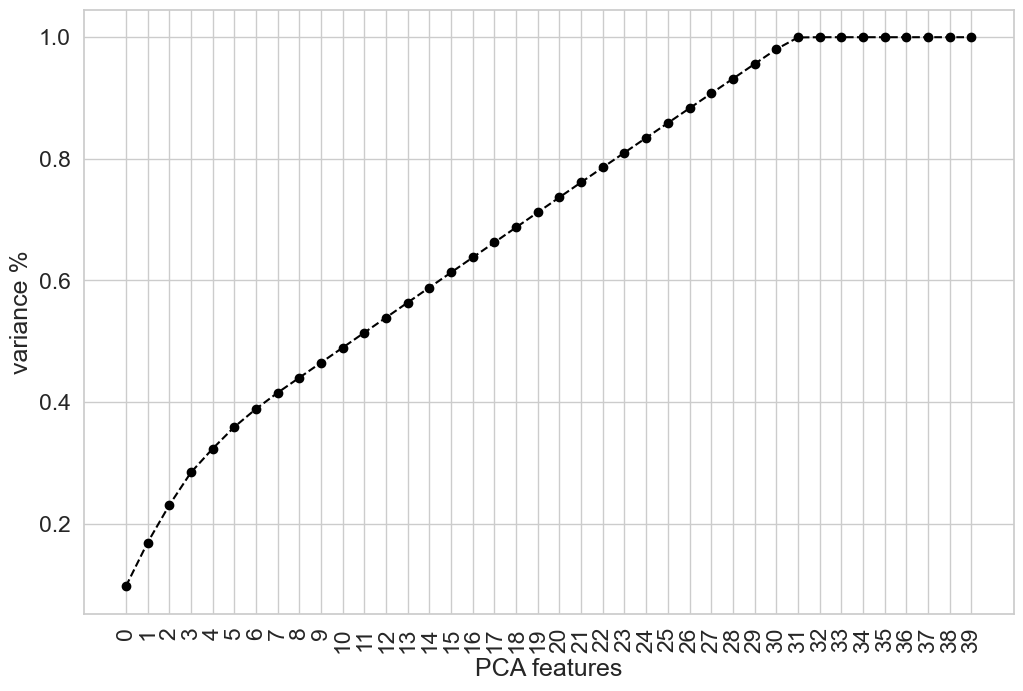

In [40]:
# from sklearn.decomposition import PCA

# fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

# pca = PCA(n_components=40)
# principalComponents = pca.fit_transform(scaled_features_df)
# # Plot the explained variances
# features = range(pca.n_components_)
# plt.plot(features, pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--' ,color='black')
# plt.xlabel('PCA features')
# plt.ylabel('variance %')
# plt.xticks(features)
# # Save components to a DataFrame
# PCA_components = pd.DataFrame(principalComponents)
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(12,8), dpi=100, facecolor='w', edgecolor='k')

pca = PCA(n_components=40)
principalComponents = pca.fit_transform(scaled_features_df)

# Plot the explained variances
features = range(pca.n_components_)
plt.plot(features, pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')

# Rotate the x-axis labels
plt.xticks(features, rotation=90)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)


Une approche du choix du nombre de composantes serait de prendre le nombre ou il y a 80% de la variance de nos données. Dans ce cas là, ca serait 23 composantes.
Celà dit ce nombre est considérable, et nous envisageons d'utiliser la pca seulement pour la visualisation de nos clusters. Nous allons essayer une autre approche ci dessous.

([<matplotlib.axis.XTick at 0x17487080a30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

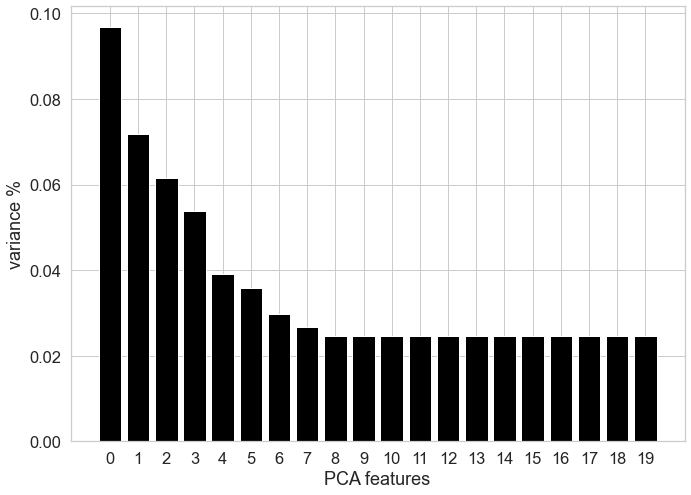

In [41]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(scaled_features_df)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_,color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

Comme on peut le constater, il y a une diminution considérable de la variance à partir du deuxieme composant, c'est à dire que la majorité de la variance de nos données se trouvent dans ces deux composantes. Nous allons donc les retenir pour réaliser les visualisation de nos clusters.

In [42]:
pca=PCA(n_components=3)
scores_pca = pca.fit_transform(scaled_features_df)
kmeans_pca=KMeans(n_clusters=4,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

In [43]:
df_segm_pca_kmeans=pd.concat([scaled_features_df.reset_index(drop=True),
pd.DataFrame(scores_pca)],axis=1)
df_segm_pca_kmeans.columns.values[-3:] = ['Component 1','Component 2','Component 3']
df_segm_pca_kmeans['Segment k-means PCA'] = kmeans_pca.labels_

In [44]:
df_segm_pca_kmeans.head()

,puissance,nbPlaces,nbPortes,prix,longueur_courte,longueur_longue,longueur_moyenne,longueur_très longue,occasion_0,occasion_1,...,full_name_Skoda_Superb 2.8 V6,full_name_Volkswagen_Golf 2.0 FSI,full_name_Volkswagen_New Beatle 1.8,full_name_Volkswagen_Polo 1.2 6V,full_name_Volkswagen_Touran 2.0 FSI,full_name_Volvo_S80 T6,Component 1,Component 2,Component 3,Segment k-means PCA
0,1.2658,-0.353553,0.319438,1.253336,-0.534522,-0.707107,-0.591608,2.097618,0.829156,-0.829156,...,-0.137361,-0.196116,-0.196116,-0.196116,-0.196116,5.09902,3.046129,-1.087162,-0.898402,2
1,1.2658,-0.353553,0.319438,1.253336,-0.534522,-0.707107,-0.591608,2.097618,0.829156,-0.829156,...,-0.137361,-0.196116,-0.196116,-0.196116,-0.196116,5.09902,3.046129,-1.087162,-0.898402,2
2,1.2658,-0.353553,0.319438,1.253336,-0.534522,-0.707107,-0.591608,2.097618,0.829156,-0.829156,...,-0.137361,-0.196116,-0.196116,-0.196116,-0.196116,5.09902,3.046129,-1.087162,-0.898402,2
3,1.2658,-0.353553,0.319438,0.456589,-0.534522,-0.707107,-0.591608,2.097618,-1.206045,1.206045,...,-0.137361,-0.196116,-0.196116,-0.196116,-0.196116,5.09902,2.693836,-1.313119,-0.368951,2
4,1.2658,-0.353553,0.319438,0.456589,-0.534522,-0.707107,-0.591608,2.097618,-1.206045,1.206045,...,-0.137361,-0.196116,-0.196116,-0.196116,-0.196116,5.09902,2.693836,-1.313119,-0.368951,2


c:\Users\missa\anaconda3\envs\virtual_workspace\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Component 2', ylabel='Component 1'>

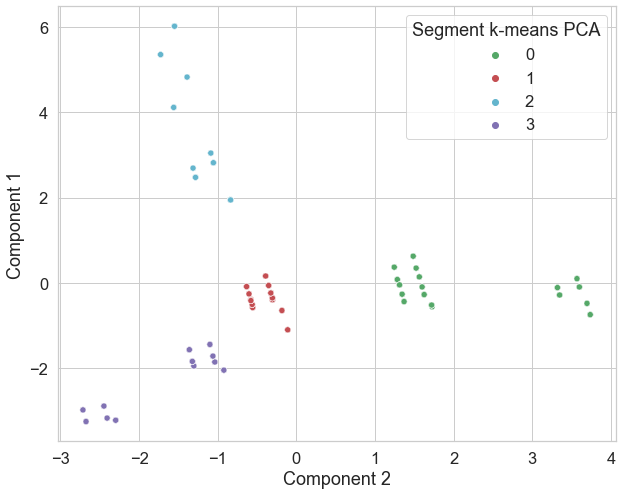

In [45]:
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize =(10,8))
sns.scatterplot(x_axis,y_axis, hue= df_segm_pca_kmeans['Segment k-means PCA'],
palette=['g','r','c','m'])

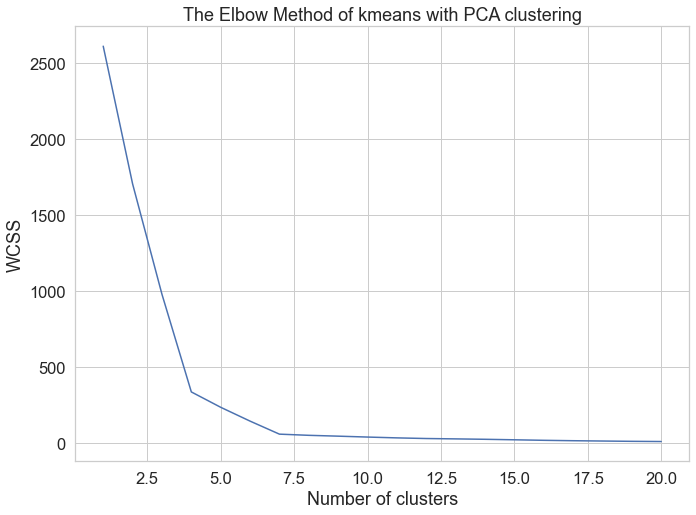

In [46]:
wcss=[]
for i in range (1,21):
    k_means_pca=KMeans(n_clusters=i,init='k-means++',random_state=42)
    k_means_pca.fit(scores_pca)
    wcss.append(k_means_pca.inertia_)
plt.plot(range(1,21),wcss)
plt.title('The Elbow Method of kmeans with PCA clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

D'apres tous les résultats précedents, on va maintenir 4 comme nombre de clusters.

## Catégorisation des clusters

In [47]:
dfe=preprocessing.StandardScaler().fit_transform(cat_dfe)
scaled_features_df = pd.DataFrame(dfe, index=cat_dfe.index, columns=cat_dfe.columns)
kmeans=KMeans(n_clusters=4, max_iter=100, random_state=0)
kmeans.fit(scaled_features_df)
scaled_features_df['cluster']=kmeans.labels_
category_df=scaled_features_df.copy()

In [48]:
category_df.cluster.value_counts()

1    100
2     70
3     60
0     40
Name: cluster, dtype: int64

In [49]:
category_df['cluster']=category_df['cluster'].map({0:'first',1:'second',2:'third',3:'fourth'})

In [50]:
categories=category_df['cluster']
cat_df['categorie']=categories

In [51]:
cat_df.categorie.value_counts()

second    100
third      70
fourth     60
first      40
Name: categorie, dtype: int64

Nous allons maintenant essayer d'identifier ces differentes catégories selon leurs caractéristiques.

Text(0.5, 1.0, 'Distribution des prix par rapport à la catégorie')

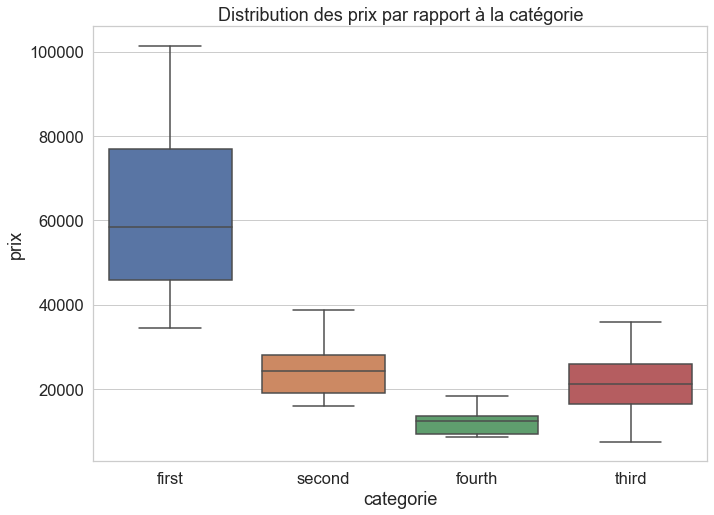

In [52]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x=cat_df['categorie'],y=cat_df['prix'])
plt.title('Distribution des prix par rapport à la catégorie')

Text(0.5, 1.0, 'Distribution de la puissance par rapport à la catégorie')

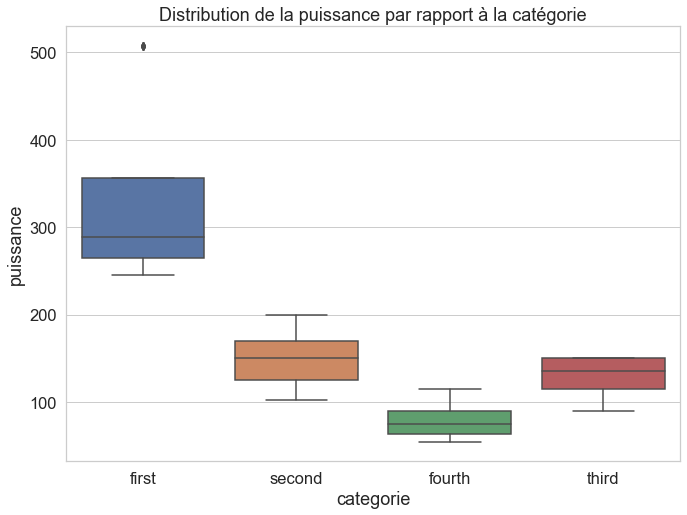

In [53]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x=cat_df['categorie'],y=cat_df['puissance'])
plt.title('Distribution de la puissance par rapport à la catégorie')

On peut remarquer que la catégorie first correspond aux voitures les plus chères et puissantes tandis que la catégorie fourth correspond aux voitures les moins cheres et les moins puissantes.

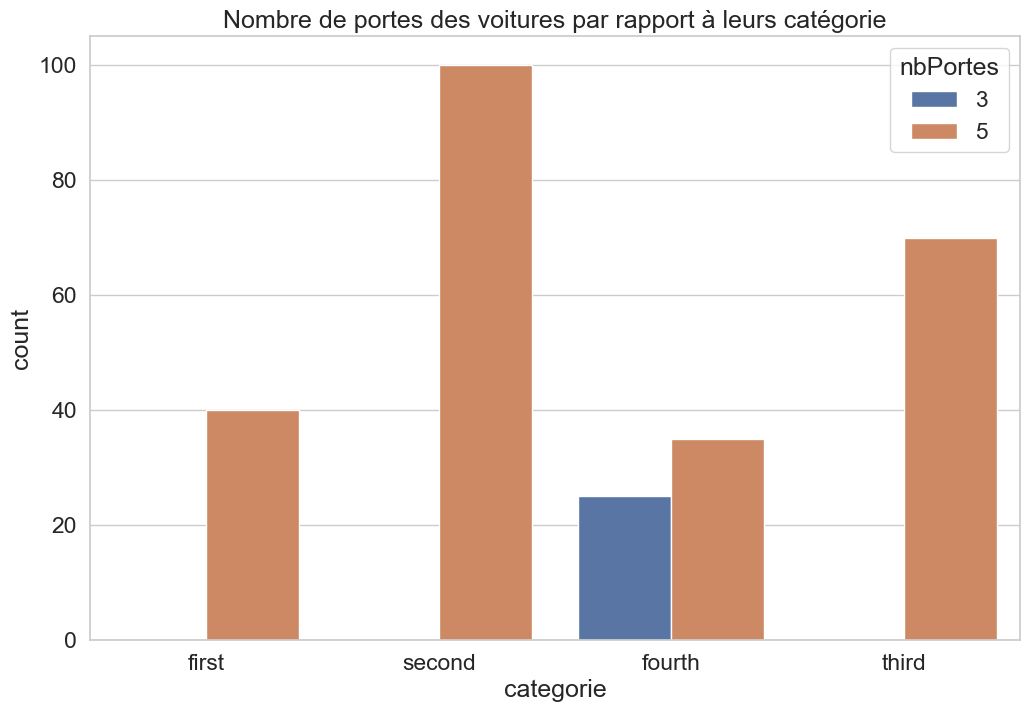

In [54]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x=cat_df.categorie,hue=cat_df.nbPortes, )
plt.title('Nombre de portes des voitures par rapport à leurs catégorie')
plt.show()


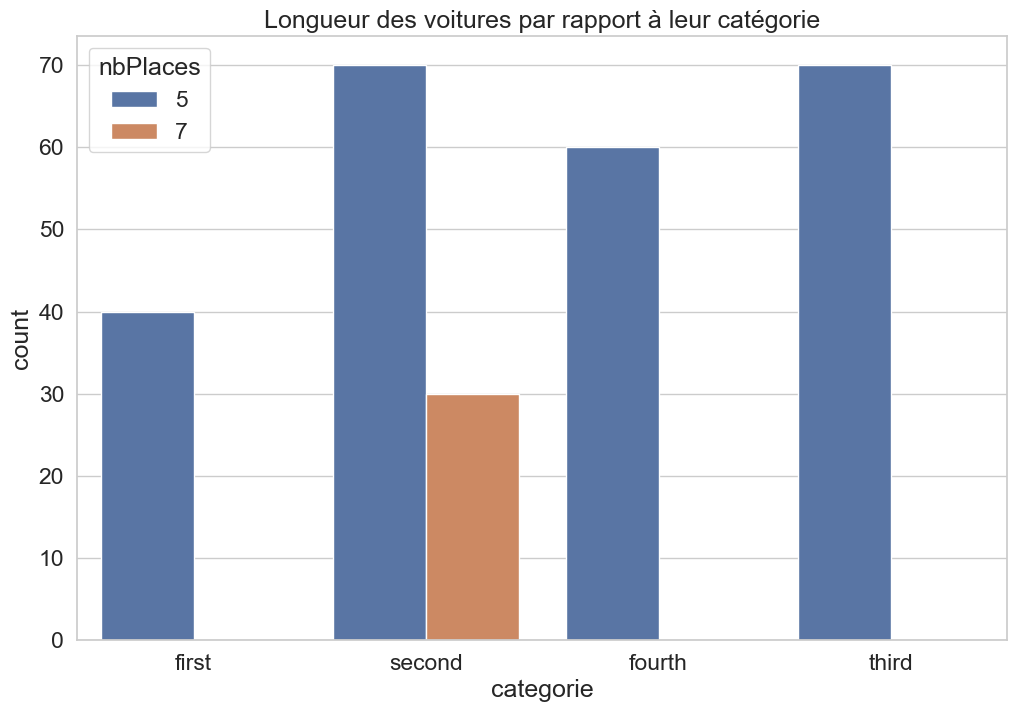

In [55]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x=cat_df.categorie,hue=cat_df.nbPlaces, )
plt.title('Longueur des voitures par rapport à leur catégorie')
plt.show()

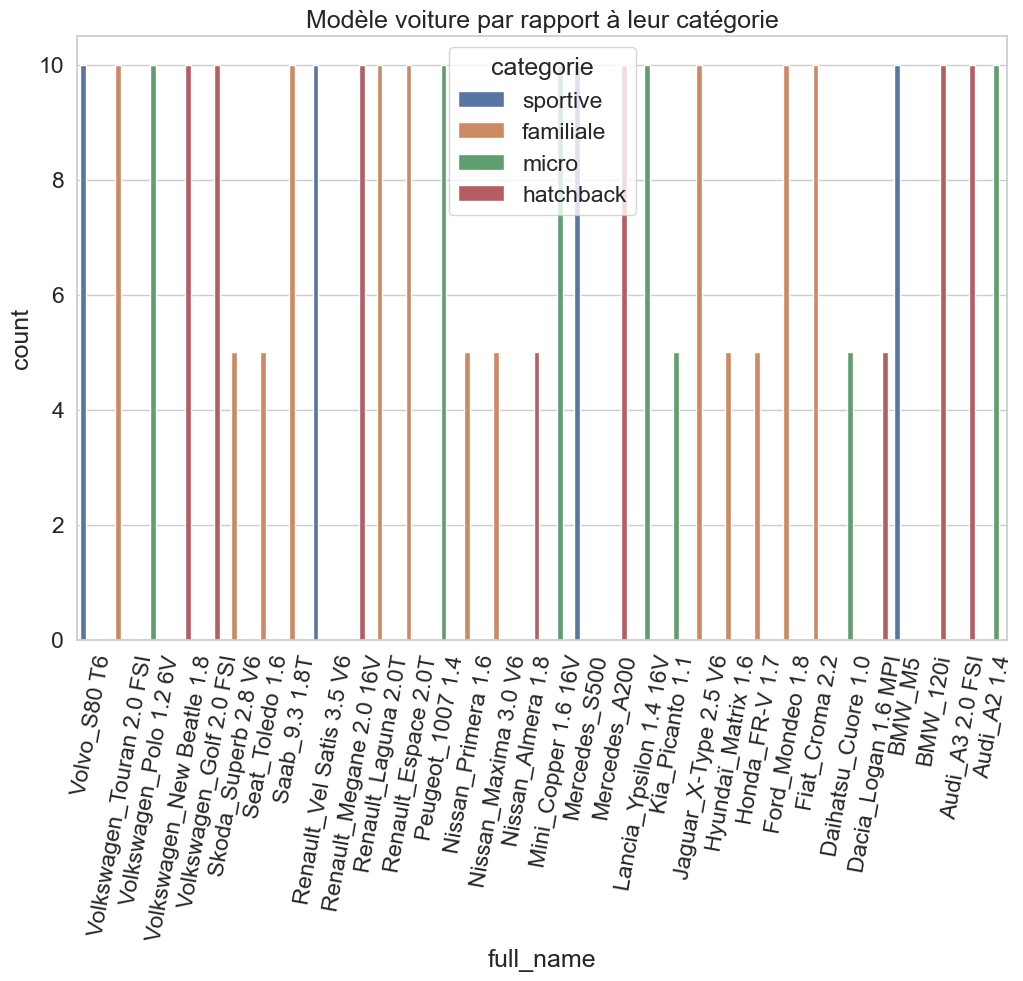

: 

In [66]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x=cat_df.full_name,hue=cat_df.categorie )
plt.title('Modèle voiture par rapport à leur catégorie')
plt.xticks(rotation=80)
plt.show()

## Hypothese 1 : 4 clusters

D'apres les modèles des voitures propres à chaque modèle, on va mettre les catégories suivantes:
- first: sportive
- second: familiale
- third: hatchback
- fourth: micro

In [57]:
cat_df['categorie']=cat_df['categorie'].map({'first':'sportive','second':'familiale','third':'hatchback','fourth':'micro'})

In [58]:
cat_df.head()

,puissance,longueur,nbPlaces,nbPortes,occasion,prix,full_name,categorie
0,272,très longue,5,5,0,50500,Volvo_S80 T6,sportive
1,272,très longue,5,5,0,50500,Volvo_S80 T6,sportive
2,272,très longue,5,5,0,50500,Volvo_S80 T6,sportive
3,272,très longue,5,5,1,35350,Volvo_S80 T6,sportive
4,272,très longue,5,5,1,35350,Volvo_S80 T6,sportive


In [59]:
categories4=cat_df['categorie']

In [60]:
new_df=pd.read_csv('C:/Users/missa/OneDrive/Bureau/Cours_Bihar/TPT/Data/Catalogue.csv',encoding='latin-1')

In [61]:
new_df['categorie']=categories4

In [62]:
new_df.tail()

,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix,categorie
265,Audi,A2 1.4,75,courte,5,5,noir,False,18310,micro
266,Audi,A2 1.4,75,courte,5,5,rouge,False,18310,micro
267,Audi,A2 1.4,75,courte,5,5,blanc,True,12817,micro
268,Audi,A2 1.4,75,courte,5,5,rouge,True,12817,micro
269,Audi,A2 1.4,75,courte,5,5,blanc,False,18310,micro


In [62]:
# new_df.to_csv('C:/Users/missa/OneDrive/Bureau/Cours_Bihar/TPT/Data/catalogue4.csv')